Train

In [1]:
import pandas as pd
import torch

ids1 = [i for i in range(30, 46)]

ids2= [f'{i}' for i in range(16)]

ids = ids1 + ids2

labels = [1] * 16 + [0] * 16

df = pd.DataFrame({'id': ids, 'label': labels})
df.to_csv('labels.csv',index=False)

In [84]:
torch.load('data_spectr/0.pt').shape

torch.Size([129, 49371])

Test

In [26]:
import pandas as pd
import torch

ids1 = [i for i in range(45, 53)]

ids2= [f'{i}' for i in range(1, 9)]

ids = ids1 + ids2

labels = [1] * 8 + [0] * 8

print(ids1, ids2)

df = pd.DataFrame({'id': ids, 'label': labels})
df.to_csv('labels2.csv',index=False)

[45, 46, 47, 48, 49, 50, 51, 52] ['1', '2', '3', '4', '5', '6', '7', '8']


In [28]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import wfdb
from scipy import signal
import numpy as np
import pandas as pd

class MyDataset(Dataset):
    def __init__(self, root='data_spectr', labels='labels.csv'):
        super().__init__()
        self.root = root
        self.labels = pd.read_csv(labels)

    def __len__(self):
        return self.labels.shape[0]
    
    def __getitem__(self, idx):
        row = self.labels.loc[idx]
        file_name = os.path.join(self.root, f'{row["id"]}.pt')
        label = row['label']
        spectrogram = torch.load(file_name)        
        spectrogram = spectrogram[:, :1500]
        return torch.stack((spectrogram, spectrogram, spectrogram), dim=0), label + 1

In [18]:
def clear_nan(rec):
        for j in range(len(rec)):
            if np.isnan(rec[j]):
                if j == 0:
                    rec[j] = rec[j + 1]
                elif j == len(rec) - 1:
                    rec[j] = rec[j - 1]
                else:
                    rec[j] = np.nanmean([rec[j - 1], rec[j + 1]])
        return rec

In [ ]:
for i in range(46):
    if i < 16 or 30<=i<=45:
        record = wfdb.rdrecord(f'data/{i}')  
        ecg_signal_1= record.p_signal[:, 1]  # Получение сигнала ЭКГ
            # ecg_signal = record.p_signal
        ecg_signal_1 = clear_nan(ecg_signal_1)
        _, _, spectrogram = signal.spectrogram(ecg_signal_1, fs=record.fs)
        spectrogram = torch.tensor(spectrogram, dtype=torch.float32)
        spectrogram = 10 * torch.log10(spectrogram)
        torch.save(spectrogram, f'data_spectr/{i}.pt')

In [27]:
for i in range(53):
    if 1<= i <= 8 or 45<=i<=52:
        record = wfdb.rdrecord(f'data_test/{i}')  
        ecg_signal_1= record.p_signal[:, 1]  # Получение сигнала ЭКГ
            # ecg_signal = record.p_signal
        ecg_signal_1 = clear_nan(ecg_signal_1)
        _, _, spectrogram = signal.spectrogram(ecg_signal_1, fs=record.fs)
        spectrogram = torch.tensor(spectrogram, dtype=torch.float32)
        spectrogram = 10 * torch.log10(spectrogram)
        torch.save(spectrogram, f'data_test_spectr/{i}.pt')

In [4]:
dataset = MyDataset()
dataloder = DataLoader(dataset, batch_size=16, shuffle=True)

In [5]:
from torchvision.models import resnet50
import torch.nn as nn

model = resnet50(weights='IMAGENET1K_V2')
model.fc = nn.Linear(2048, 2)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <9DBE5D5C-AC87-30CA-96DA-F5BC116EDA2B> /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <E854E4B4-D8A9-321E-9852-69F8F3B956BB> /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [9]:
from tqdm import tqdm
#optim = torch.optim.Adam(model.parameters(), lr = 1e-3)
optim = torch.optim.SGD(model.parameters(), lr = 1e-2)
criterion = torch.nn.CrossEntropyLoss()
device = torch.device('mps')
model.to(device)

losses = []
accuracy = []

for epoch in range(30):
    l = 0
    acc = 0
    for (img, labels) in dataloder:
        img = img.to(device)
        labels = labels.to(device)
        optim.zero_grad()
        logits = model(img)
        loss = criterion(logits, labels)
        loss.backward()
        l += loss.item()
        acc += (logits.argmax(1) == (labels - 1)).sum()
    losses.append(l / 32)
    accuracy.append(acc.item() / 32)



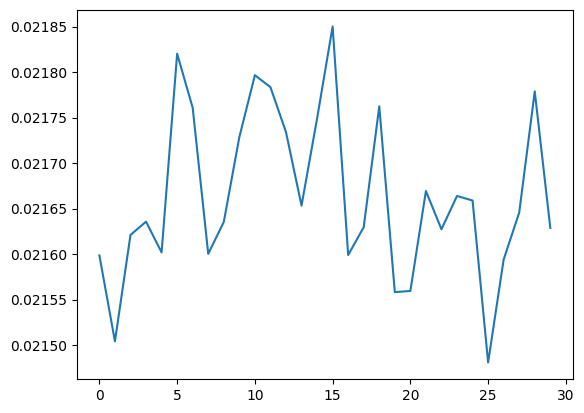

In [10]:
import matplotlib.pyplot as plt
plt.plot(losses)

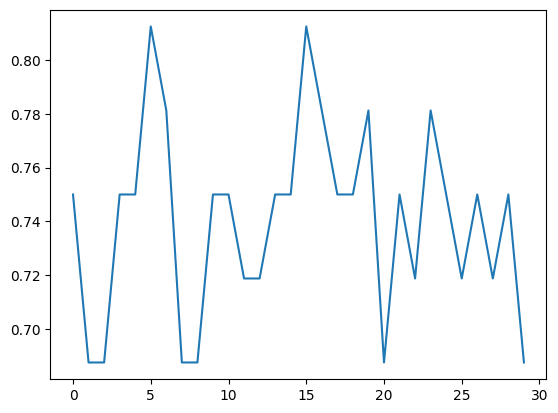

In [11]:
plt.plot(accuracy)

In [35]:
test_dataset = MyDataset(root='data_test_spectr', labels='labels2.csv')
test_loader = DataLoader(test_dataset, batch_size=16)

model.to(device)


ac = 0
for img, labelss in test_loader:
    with torch.no_grad():
        img = img.to(device)
        logits = model(img)
        predict = (logits.argmax(1)).cpu()
        ac += (predict == labelss - 1).sum()
ac / len(test_dataset)

tensor(0.6875)

In [36]:
from sklearn.metrics import confusion_matrix
y_true = [1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0]
confusion_matrix(y_true, predict)


array([[3, 5],
       [0, 8]])

In [28]:
import wfdb
from scipy import signal
record = wfdb.rdrecord('data/30')  
ecg_signal_1 = record.p_signal[:, 1]
frequencies, times, spectrogram = signal.spectrogram(ecg_signal_1, fs=record.fs)


In [36]:
import numpy as np

clear_nan(ecg_signal_1)
frequencies, times, spectrogram = signal.spectrogram(ecg_signal_1, fs=record.fs)
print(spectrogram.min())

1.2998821243359255e-17
